<a href="https://colab.research.google.com/github/ORAzzQWQ/NLP_2024/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install torch==2.4.0
# !pip install transformers==4.37.0
!pip install datasets==2.21.0
!pip install accelerate==0.21.0
!pip install scikit-learn==1.5.2
!pip install torchmetrics

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.6.1 which is incompatible.
   ━━━━━━━━━━━

In [ ]:
import transformers as T
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from torchmetrics import SpearmanCorrCoef, Accuracy, F1Score
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# 有些中文的標點符號在tokenizer編碼以後會變成[UNK]，所以將其換成英文標點
token_replacement = [
    ["：" , ":"],
    ["，" , ","],
    ["“" , "\""],
    ["”" , "\""],
    ["？" , "?"],
    ["……" , "..."],
    ["！" , "!"]
]

In [ ]:
class SemevalDataset(Dataset):
    def __init__(self, split="train") -> None:
        super().__init__()
        assert split in ["train", "validation"]
        self.data = load_dataset(
            "sem_eval_2014_task_1", split=split, cache_dir="./cache/"
        ).to_list()

    def __getitem__(self, index):
        d = self.data[index]
        # 把中文標點替換掉
        for k in ["premise", "hypothesis"]:
            for tok in token_replacement:
                d[k] = d[k].replace(tok[0], tok[1])
        return d

    def __len__(self):
        return len(self.data)

data_sample = SemevalDataset(split="train").data[:3]
print(f"Dataset example: \n{data_sample[0]} \n{data_sample[1]} \n{data_sample[2]}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for sem_eval_2014_task_1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sem_eval_2014_task_1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/4500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4927 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset example: 
{'sentence_pair_id': 1, 'premise': 'A group of kids is playing in a yard and an old man is standing in the background', 'hypothesis': 'A group of boys in a yard is playing and a man is standing in the background', 'relatedness_score': 4.5, 'entailment_judgment': 0} 
{'sentence_pair_id': 2, 'premise': 'A group of children is playing in the house and there is no man standing in the background', 'hypothesis': 'A group of kids is playing in a yard and an old man is standing in the background', 'relatedness_score': 3.200000047683716, 'entailment_judgment': 0} 
{'sentence_pair_id': 3, 'premise': 'The young boys are playing outdoors and the man is smiling nearby', 'hypothesis': 'The kids are playing outdoors near a man with a smile', 'relatedness_score': 4.699999809265137, 'entailment_judgment': 1}


In [ ]:
train_dataset = SemevalDataset(split="train")
validation_dataset = SemevalDataset(split="validation")

tokenizer = T.BertTokenizer.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Define the hyperparameters
lr = 3e-5
epochs = 3
train_batch_size = 8
validation_batch_size = 8

In [ ]:
# TODO1: Create batched data for DataLoader
# `collate_fn` is a function that defines how the data batch should be packed.
# This function will be called in the DataLoader to pack the data batch.
# ASK WITH Claude

def collate_fn(batch):
    # TODO1-1: Implement the collate_fn function
    # Write your code here
    # The input parameter is a data batch (tuple), and this function packs it into tensors.
    premises = [item['premise'] for item in batch]
    hypotheses = [item['hypothesis'] for item in batch]
    entailment_labels = torch.tensor([item['entailment_judgment'] for item in batch])
    relatedness_score = torch.tensor([item['relatedness_score'] for item in batch])

    # Use tokenizer to pack tokenize and pack the data and its corresponding labels.
    encoded = tokenizer(
        premises,
        hypotheses,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

    # Return the data batch and labels for each sub-task.
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'], # tokenizer自動生成的mask [pad]的東東
        'entailment_labels': entailment_labels,
        'relatedness_score': relatedness_score
    }

# TODO1-2: Define your DataLoader
dl_train = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
dl_validation = DataLoader(
    validation_dataset,
    batch_size=validation_batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

In [ ]:
# TODO2: Construct your model
# ASK WITH Claude

class MultiLabelModel(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Write your code here
        # Define what modules you will use in the model
        self.bert = T.BertModel.from_pretrained('bert-base-uncased') # 預設是可以更新的

        # # 可以選擇只更新某些層
        # for param in self.bert.embeddings.parameters():
        #     param.requires_grad = False  # 凍結 embedding 層

        # for i, layer in enumerate(self.bert.encoder.layer):
        #     # 例如：只更新最後4層
        #     if i < 8:  # BERT有12層，凍結前8層
        #         for param in layer.parameters():
        #             param.requires_grad = False

        self.dropout = torch.nn.Dropout(0.1)

        # 1. 相似度分數 (回歸任務)
        self.similarity_head = torch.nn.Linear(768, 1)
        # 2. 蘊含判斷 (分類任務)
        self.entailment_head = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask): # 明確定義需要的參數,不然會報錯(ASK WITH Claude)
        # Write your code here
        # Forward pass
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        # 產生預測
        similarity_scores = self.similarity_head(pooled_output).squeeze(-1)
        entailment_logits = self.entailment_head(pooled_output)

        return similarity_scores, entailment_logits

In [ ]:
# ASK WITH Claude
model = MultiLabelModel().to(device)
# TODO3: Define your optimizer and loss function

# TODO3-1: Define your Optimizer
optimizer = AdamW(model.parameters(), lr=lr)

# TODO3-2: Define your loss functions (you should have two)
# Write your code here
similarity_loss_fn = torch.nn.MSELoss()  # 回歸任務用MSE
entailment_loss_fn = torch.nn.CrossEntropyLoss()  # 分類任務用CrossEntropy

# scoring functions
spc = SpearmanCorrCoef().to(device)
acc = Accuracy(task='multiclass', num_classes=3).to(device)  # 因為entailment是3分類任務
f1 = F1Score(task='multiclass', num_classes=3, average='macro').to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [ ]:
# ASK WITH Claude

for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    model.train()

    for batch in pbar:
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        relatedness_score = batch['relatedness_score'].float().to(device)
        entailment_labels = batch['entailment_labels'].to(device)

        optimizer.zero_grad()
        similarity_preds, entailment_logits = model(input_ids=input_ids, attention_mask=attention_mask)

        similarity_loss = similarity_loss_fn(similarity_preds, relatedness_score)
        entailment_loss = entailment_loss_fn(entailment_logits, entailment_labels)
        total_loss = similarity_loss + entailment_loss

        total_loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=total_loss.item())

    # Evaluation
    pbar = tqdm(dl_validation)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    model.eval()

    similarity_preds_list = []
    similarity_labels_list = []
    entailment_preds_list = []
    entailment_labels_list = []

    with torch.no_grad():
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            similarity_labels = batch['relatedness_score'].float().to(device)
            entailment_labels = batch['entailment_labels'].to(device)

            similarity_preds, entailment_logits = model(input_ids, attention_mask)

            # Keep everything on GPU
            similarity_preds_list.append(similarity_preds)
            similarity_labels_list.append(similarity_labels)

            entailment_preds = torch.argmax(entailment_logits, dim=1)
            entailment_preds_list.append(entailment_preds)
            entailment_labels_list.append(entailment_labels)

    # Concatenate all predictions and labels while keeping them on GPU
    all_similarity_preds = torch.cat(similarity_preds_list)
    all_similarity_labels = torch.cat(similarity_labels_list)
    all_entailment_preds = torch.cat(entailment_preds_list)
    all_entailment_labels = torch.cat(entailment_labels_list)

    # Calculate metrics (all tensors now on same device)
    spearman = spc(all_similarity_preds, all_similarity_labels)
    accuracy = acc(all_entailment_preds, all_entailment_labels)
    f1_score = f1(all_entailment_preds, all_entailment_labels)

    print(f"\nValidation Metrics:")
    print(f"- Spearman Correlation: {spearman:.4f}")
    print(f"- Accuracy: {accuracy:.4f}")
    print(f"- F1 Score: {f1_score:.4f}")

    # Save model checkpoint
    torch.save(model.state_dict(), f'./ep{ep+1}.ckpt')

Validation epoch [1/3]: 100%|██████████| 63/63 [00:01<00:00, 61.48it/s]



Validation Metrics:
- Spearman Correlation: 0.7945
- Accuracy: 0.8360
- F1 Score: 0.8425


Validation epoch [2/3]: 100%|██████████| 63/63 [00:01<00:00, 60.97it/s]



Validation Metrics:
- Spearman Correlation: 0.8110
- Accuracy: 0.8600
- F1 Score: 0.8554


Validation epoch [3/3]: 100%|██████████| 63/63 [00:01<00:00, 61.14it/s]



Validation Metrics:
- Spearman Correlation: 0.8255
- Accuracy: 0.8620
- F1 Score: 0.8585


For test set predictions, you can write perform evaluation simlar to #TODO5.

In [ ]:
# ASK WITH Claude
# Performance comparison experiments

print("\n=== Starting Performance Comparison Experiments ===")

# 1. Single-task Models
class SimilarityOnlyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = T.BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(0.1)
        self.similarity_head = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        similarity_scores = self.similarity_head(pooled_output)
        return similarity_scores.squeeze(-1)

class EntailmentOnlyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = T.BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(0.1)
        self.entailment_head = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        entailment_logits = self.entailment_head(pooled_output)
        return entailment_logits

def train_single_task(model, task_type, epochs=3):
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)

    if task_type == 'similarity':
        criterion = torch.nn.MSELoss()
    else:  # entailment
        criterion = torch.nn.CrossEntropyLoss()

    results = {
        'train_loss': [],
        'val_metrics': []
    }

    for ep in range(epochs):
        # Training
        model.train()
        total_loss = 0
        pbar = tqdm(dl_train)
        pbar.set_description(f"Training {task_type} epoch [{ep+1}/{epochs}]")

        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            if task_type == 'similarity':
                labels = batch['relatedness_score'].float().to(device)
                outputs = model(input_ids, attention_mask)
            else:
                labels = batch['entailment_labels'].to(device)
                outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(dl_train)
        results['train_loss'].append(avg_loss)

        # Validation
        model.eval()
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for batch in tqdm(dl_validation, desc=f"Validation {task_type} epoch [{ep+1}/{epochs}]"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                if task_type == 'similarity':
                    labels = batch['relatedness_score'].float().to(device)
                    outputs = model(input_ids, attention_mask)
                else:
                    labels = batch['entailment_labels'].to(device)
                    outputs = model(input_ids, attention_mask)
                    outputs = torch.argmax(outputs, dim=1)

                # 保持在GPU上
                val_preds.append(outputs)
                val_labels.append(labels)

        # 在GPU上合併預測結果
        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)

        # 計算指標
        if task_type == 'similarity':
            spearman = spc(val_preds, val_labels)
            results['val_metrics'].append({'spearman': spearman.item()})
            print(f"Spearman correlation: {spearman:.4f}")
        else:
            accuracy = acc(val_preds, val_labels)
            f1_score = f1(val_preds, val_labels)
            results['val_metrics'].append({
                'accuracy': accuracy.item(),
                'f1': f1_score.item()
            })
            print(f"Accuracy: {accuracy:.4f}, F1: {f1_score:.4f}")

    return results

def print_comparison():
    print("\n=== Performance Comparison ===")
    print("\nSingle-task Models Results:")
    print("Similarity (Spearman):", [f"{m['spearman']:.4f}" for m in sim_results['val_metrics']])
    print("Entailment Results:", ent_results['val_metrics'])

# Run experiments
print("\nTraining Similarity-Only Model...")
sim_model = SimilarityOnlyModel()
sim_results = train_single_task(sim_model, 'similarity')

print("\nTraining Entailment-Only Model...")
ent_model = EntailmentOnlyModel()
ent_results = train_single_task(ent_model, 'entailment')

# 顯示結果
print_comparison()


=== Starting Performance Comparison Experiments ===

Training Similarity-Only Model...


Validation similarity epoch [1/3]: 100%|██████████| 63/63 [00:01<00:00, 56.35it/s]


Spearman correlation: 0.7998


Validation similarity epoch [2/3]: 100%|██████████| 63/63 [00:01<00:00, 56.92it/s]


Spearman correlation: 0.8178


Validation similarity epoch [3/3]: 100%|██████████| 63/63 [00:01<00:00, 51.80it/s]


Spearman correlation: 0.8333

Training Entailment-Only Model...


Validation entailment epoch [1/3]: 100%|██████████| 63/63 [00:01<00:00, 50.09it/s]


Accuracy: 0.8220, F1: 0.8276


Validation entailment epoch [2/3]: 100%|██████████| 63/63 [00:01<00:00, 53.85it/s]


Accuracy: 0.8380, F1: 0.8381


Validation entailment epoch [3/3]: 100%|██████████| 63/63 [00:01<00:00, 56.05it/s]

Accuracy: 0.8400, F1: 0.8337

=== Performance Comparison ===

Single-task Models Results:
Similarity (Spearman): ['0.7998', '0.8178', '0.8333']
Entailment Results: [{'accuracy': 0.8220000267028809, 'f1': 0.8276069164276123}, {'accuracy': 0.8379999995231628, 'f1': 0.8381458520889282}, {'accuracy': 0.8399999737739563, 'f1': 0.8337022066116333}]


Error Analysis: 100%|██████████| 63/63 [00:03<00:00, 18.35it/s]
<ipython-input-12-5916fe68d580>:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(sim_errors.groupby(pd.qcut(sim_errors['length'], 4))['error'].mean())
<ipython-input-12-5916fe68d580>:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(sim_errors.groupby(pd.qcut(sim_errors['complexity'], 4))['error'].mean())
<ipython-input-12-5916fe68d580>:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the


=== Similarity Task Error Analysis ===

Total similarity errors: 27

Top 5 largest errors:
                                              premise  predicted  true  \
18  a white dog is wearing a christmas reindeer he...   3.849023   2.2   
22  a woman dressed in elegant clothing is inside ...   4.662544   3.1   
2   a man is playing flute a man is playing a game...   3.036540   1.5   
15          a person is dancing a woman is exercising   1.528326   3.0   
21  a man and two women in a darkened room are sit...   3.947984   2.5   

       error  
18  1.649023  
22  1.562544  
2   1.536540  
15  1.471674  
21  1.447984  

Error distribution:
count    27.000000
mean      1.220200
std       0.190317
min       1.001996
25%       1.067471
50%       1.155431
75%       1.342036
max       1.649023
Name: error, dtype: float64

=== Entailment Task Error Analysis ===

Total entailment errors: 69

Confusion Matrix:
Predicted   0   1  2
True                
0           0  23  6
1          29   0  0


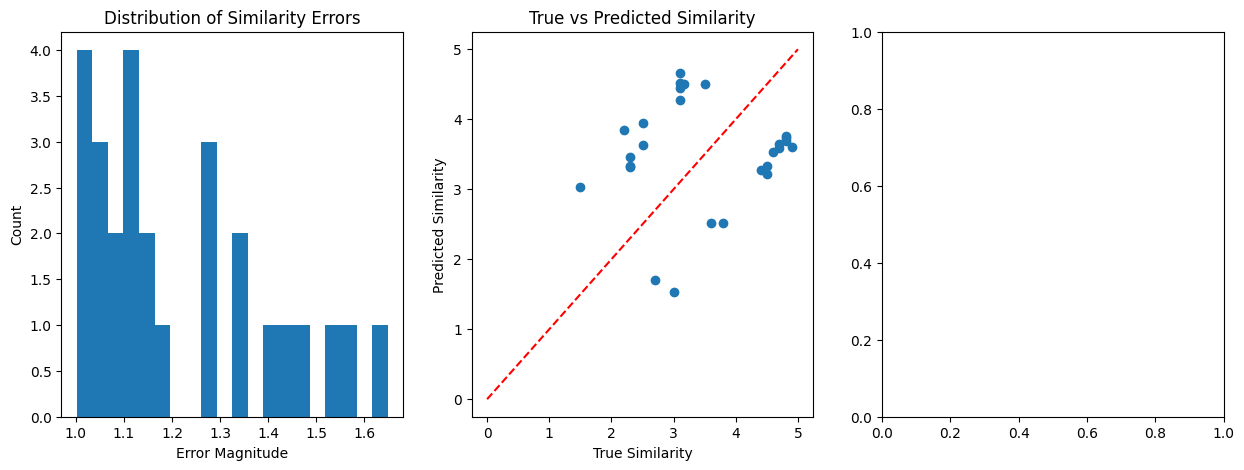

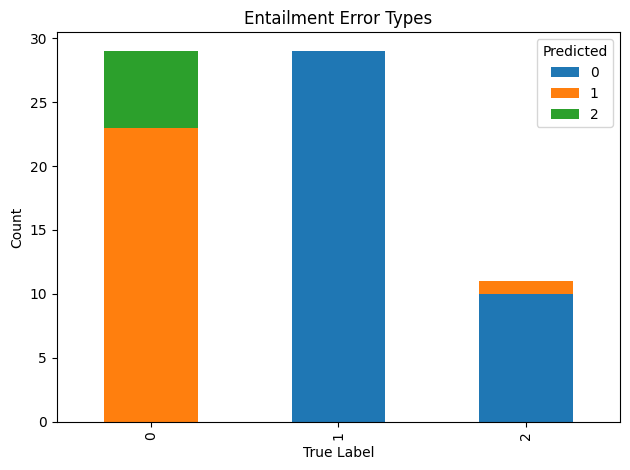

In [ ]:
# ASK WITH Claude
# error analysis
import pandas as pd

def error_analysis(model, dataloader, tokenizer):
    model.eval()
    errors = {
        'similarity': [],
        'entailment': []
    }

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Error Analysis"):
            # 移動到GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # 獲取預測
            sim_scores, ent_logits = model(input_ids, attention_mask)
            ent_preds = torch.argmax(ent_logits, dim=1)

            # 獲取真實標籤
            true_sim = batch['relatedness_score'].float().to(device)
            true_ent = batch['entailment_labels'].to(device)

            # 找出錯誤案例
            # 相關度誤差較大的案例 (誤差 > 1.0)
            sim_errors = torch.abs(sim_scores - true_sim) > 1.0
            # 蘊含關係預測錯誤的案例
            ent_errors = ent_preds != true_ent

            # 收集錯誤案例的詳細信息
            for idx in range(len(input_ids)):
                premise = tokenizer.decode(input_ids[idx], skip_special_tokens=True)

                if sim_errors[idx]:
                    errors['similarity'].append({
                        'premise': premise,
                        'predicted': sim_scores[idx].item(),
                        'true': true_sim[idx].item(),
                        'error': abs(sim_scores[idx].item() - true_sim[idx].item())
                    })

                if ent_errors[idx]:
                    errors['entailment'].append({
                        'premise': premise,
                        'predicted': ent_preds[idx].item(),
                        'true': true_ent[idx].item()
                    })

    return errors

# 進行錯誤分析
errors = error_analysis(model, dl_validation, tokenizer)

# 分析相關度任務的錯誤
print("\n=== Similarity Task Error Analysis ===")
sim_errors = pd.DataFrame(errors['similarity'])
if len(sim_errors) > 0:
    print(f"\nTotal similarity errors: {len(sim_errors)}")
    print("\nTop 5 largest errors:")
    print(sim_errors.nlargest(5, 'error')[['premise', 'predicted', 'true', 'error']])

    # 錯誤分布分析
    print("\nError distribution:")
    print(sim_errors['error'].describe())

# 分析蘊含任務的錯誤
print("\n=== Entailment Task Error Analysis ===")
ent_errors = pd.DataFrame(errors['entailment'])
if len(ent_errors) > 0:
    print(f"\nTotal entailment errors: {len(ent_errors)}")

    # 混淆矩陣
    confusion = pd.crosstab(
        ent_errors['true'],
        ent_errors['predicted'],
        rownames=['True'],
        colnames=['Predicted']
    )
    print("\nConfusion Matrix:")
    print(confusion)

    # 錯誤案例分析
    print("\nSample error cases:")
    print(ent_errors.sample(5)[['premise', 'predicted', 'true']])

# 錯誤模式分析
def analyze_error_patterns():
    # 1. 句子長度分析
    sim_errors['length'] = sim_errors['premise'].str.len()
    print("\nSimilarity errors by sentence length:")
    print(sim_errors.groupby(pd.qcut(sim_errors['length'], 4))['error'].mean())

    # 2. 語言複雜度分析（使用簡單的指標）
    def complexity_score(text):
        words = text.split()
        return sum(len(word) for word in words) / len(words)

    sim_errors['complexity'] = sim_errors['premise'].apply(complexity_score)
    print("\nErrors by text complexity:")
    print(sim_errors.groupby(pd.qcut(sim_errors['complexity'], 4))['error'].mean())

    # 3. 相關度範圍分析
    print("\nErrors by true similarity score range:")
    print(sim_errors.groupby(pd.qcut(sim_errors['true'], 4))['error'].mean())

analyze_error_patterns()

# 可視化分析
def plot_error_analysis():
    plt.figure(figsize=(15, 5))

    # 1. 相關度錯誤分布
    plt.subplot(1, 3, 1)
    plt.hist(sim_errors['error'], bins=20)
    plt.title('Distribution of Similarity Errors')
    plt.xlabel('Error Magnitude')
    plt.ylabel('Count')

    # 2. 真實值vs預測值散點圖
    plt.subplot(1, 3, 2)
    plt.scatter(sim_errors['true'], sim_errors['predicted'])
    plt.plot([0, 5], [0, 5], 'r--')  # 理想線
    plt.title('True vs Predicted Similarity')
    plt.xlabel('True Similarity')
    plt.ylabel('Predicted Similarity')

    # 3. 錯誤類型的比例
    plt.subplot(1, 3, 3)
    confusion.plot(kind='bar', stacked=True)
    plt.title('Entailment Error Types')
    plt.xlabel('True Label')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

plot_error_analysis()